In [4]:
import uproot
import numpy as np
import scipy.stats as sps
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from scipy.spatial.transform import Rotation as R
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from pylorentz import Momentum4, Position4
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
tree_tt = uproot.open("../MVAFILE_AllHiggs_tt_new.root")["ntuple"]
print('loaded root file')
variables = [
            "wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand",
            "aco_angle_1", 
#             "aco_angle_5", "aco_angle_6", "aco_angle_7", 
            "mva_dm_1","mva_dm_2",
            "tau_decay_mode_1","tau_decay_mode_2",
#             "ip_x_1", "ip_y_1", "ip_z_1", "ip_x_2", "ip_y_2", "ip_z_2", # ignore impact parameter for now
            "pi_E_1", "pi_px_1", "pi_py_1", "pi_pz_1", 
            "pi_E_2", "pi_px_2", "pi_py_2", "pi_pz_2", 
            "pi0_E_1", "pi0_px_1", "pi0_py_1", "pi0_pz_1",
            "pi0_E_2", "pi0_px_2", "pi0_py_2", "pi0_pz_2", 
            "y_1_1", "y_1_2",
            'met', 'metx', 'mety',
        #     'sv_x_1', 'sv_y_1', 'sv_z_1', 'sv_x_2', 'sv_y_2','sv_z_2'
        ]
# variables += ["gen_nu_p_1", "gen_nu_phi_1", "gen_nu_eta_1", #leading neutrino, gen level
#             "gen_nu_p_2", "gen_nu_phi_2", "gen_nu_eta_2" #subleading neutrino, gen level
#              ]
df_tt = tree_tt.pandas.df(variables)
print('loaded df')
# select only rho-rho events
df_rho = df_tt[(df_tt['mva_dm_1']==1) & (df_tt['mva_dm_2']==1) & (df_tt["tau_decay_mode_1"] == 1) & (df_tt["tau_decay_mode_2"] == 1)]
# drop unnecessary labels 
df = df_rho.drop(["mva_dm_1","mva_dm_2","tau_decay_mode_1","tau_decay_mode_2", "wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand"], axis=1).reset_index(drop=True)
print('finished rho-rho loading')

In [5]:
df_tt = pd.read_pickle('./df_tt.pkl')
df_rho = df_tt[(df_tt['mva_dm_1']==1) & (df_tt['mva_dm_2']==1) & (df_tt["tau_decay_mode_1"] == 1) & (df_tt["tau_decay_mode_2"] == 1)]
df_reco = df_rho.drop(["mva_dm_1","mva_dm_2","tau_decay_mode_1","tau_decay_mode_2", "wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand"], axis=1).reset_index(drop=True)

In [8]:
df_tt_gen = pd.read_pickle('./df_tt_gen.pkl')
df_rho = df_tt_gen[(df_tt_gen['dm_1']==1) & (df_tt_gen['dm_2']==1)]
df_gen = df_rho.drop(["dm_1","dm_2","wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand"], axis=1).reset_index(drop=True)

In [6]:
def get_products(df_reco):
    pi_1 = Momentum4(df_reco['pi_E_1'], df_reco["pi_px_1"], df_reco["pi_py_1"], df_reco["pi_pz_1"])
    pi_2 = Momentum4(df_reco['pi_E_2'], df_reco["pi_px_2"], df_reco["pi_py_2"], df_reco["pi_pz_2"])
    pi0_1 = Momentum4(df_reco['pi0_E_1'], df_reco["pi0_px_1"], df_reco["pi0_py_1"], df_reco["pi0_pz_1"])
    pi0_2 = Momentum4(df_reco['pi0_E_2'], df_reco["pi0_px_2"], df_reco["pi0_py_2"], df_reco["pi0_pz_2"])
    rho_1 = pi_1 + pi0_1
    rho_2 = pi_2 + pi0_2
    return pi_1, pi_2, pi0_1, pi0_2, rho_1, rho_2

In [ ]:
ip_1 = np.c_[df_reco['ip_x_1'], df_reco['ip_y_1'], df_reco['ip_z_1']]
ip_2 = np.c_[df_reco['ip_x_2'], df_reco['ip_y_2'], df_reco['ip_z_2']]

## investigating gen SV and p_t_vis

In [ ]:
df_gen.keys()

In [9]:
sv_df = df_gen[['sv_x_1', 'sv_y_1', 'sv_z_1', 'sv_x_2', 'sv_y_2', 'sv_z_2']]
pi_1, pi_2, pi0_1, pi0_2, rho_1, rho_2 = get_products(df_gen)
sv_df['p_t_vis_1'] = rho_1.p
sv_df['p_t_vis_2'] = rho_2.p

<ipython-input-9-90836dda2a75>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sv_df['p_t_vis_1'] = rho_1.p
<ipython-input-9-90836dda2a75>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sv_df['p_t_vis_2'] = rho_2.p


In [10]:
sv_df.head()

,sv_x_1,sv_y_1,sv_z_1,sv_x_2,sv_y_2,sv_z_2,p_t_vis_1,p_t_vis_2
0,0.023583,0.019393,0.005763,-0.581665,-0.513909,0.018126,33.753041,52.583766
1,0.264949,-0.061602,-0.161944,-0.120283,-0.045656,-0.260196,37.600309,127.553300
2,0.238845,0.233997,0.112015,-0.280071,0.057288,0.059971,59.091590,67.625778
3,-0.005463,0.055390,0.092998,0.429833,-1.008276,3.836661,65.426963,145.224950
4,0.066919,0.085073,-0.095757,0.065669,0.054346,0.027046,56.050964,80.801777


In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(sv_df, title='Pandas Profiling Report', explorative=True)

In [ ]:
profile.to_widgets()

In [ ]:
profile.to_file("sv_df.html")

In [ ]:
# p_t_vis_1 = rho_1.p
# p_t_vis_2 = rho_2.p
# sv_x_1, sv_y_1, sv_z_1 = sv_df['sv_x_1'], sv_df['sv_y_1'], sv_df['sv_z_1'] 
# sv_x_2, sv_y_2, sv_z_2 = sv_df['sv_x_2'], sv_df['sv_y_2'], sv_df['sv_z_2']

In [ ]:
plt.figure()
plt.hist(sv_df['sv_z_1'], bins=100)
plt.show()

In [ ]:
plt.clf()

In [ ]:
# %matplotlib notebook
def three_d_scatterplot(p_t_vis, sv_x, sv_y, sv_z, samples=10000):
    idx = np.random.choice(np.arange(len(p_t_vis)), samples, replace=False)
    p_t_vis = p_t_vis[idx]
    sv_x = sv_x[idx]
    sv_y = sv_y[idx]
    sv_z = sv_z[idx]
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    img = ax.scatter(sv_x, sv_y, sv_z, c=p_t_vis, cmap=plt.hot())
    fig.colorbar(img)
    plt.show()


In [77]:
def profileplot(x, y, xlabel, ylabel, bins=100, mode=1):
    means_result = sps.binned_statistic(x, [y, y**2], bins=bins, statistic='mean')
    means, means2 = means_result.statistic
    standard_deviations = np.sqrt(means2 - means**2)
    bin_edges = means_result.bin_edges
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    # remove NaNs and single count bins
    nan_idx = np.argwhere(np.isnan(means) ).flatten()
    zero_idx = np.argwhere(standard_deviations == 0)
    to_remove = np.union1d(nan_idx, zero_idx)
    means = np.delete(means, to_remove, None)
    bin_centers = np.delete(bin_centers, to_remove, None)
    standard_deviations = np.delete(standard_deviations, to_remove, None)
    count = Counter(means_result.binnumber)
    to_remove_set = set(to_remove)
    N = []
    for i in range(1,bins+1):
        if i-1 in to_remove_set:
            continue
        if i in count:
            N.append(count[i])
#     print(to_remove.shape)
#     print(bin_centers.shape, means.shape)
    yerr = standard_deviations/np.sqrt(N)
#     yerr = standard_deviations
    # fitting
#     print(bin_centers, means, yerr)
    if mode == 1:
        fit, cov = np.polyfit(bin_centers, means, 1, w=1/yerr, cov=True)
        p = np.poly1d(fit)
        print(f"Fit params: {fit[0]}, {fit[1]}")
        print(f"Diag of cov: {cov[0][0]} , {cov[1][1]}")
    plt.figure()
    plt.errorbar(x=bin_centers, y=means, yerr=yerr, linestyle='none', marker='.', capsize=2)
    if mode == 1:
        plt.plot(bin_centers, p(bin_centers))
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    return fit, cov, bin_centers, means
plt.rcParams.update({'font.size': 14, "figure.figsize": (10,6)})

# double checking SV length

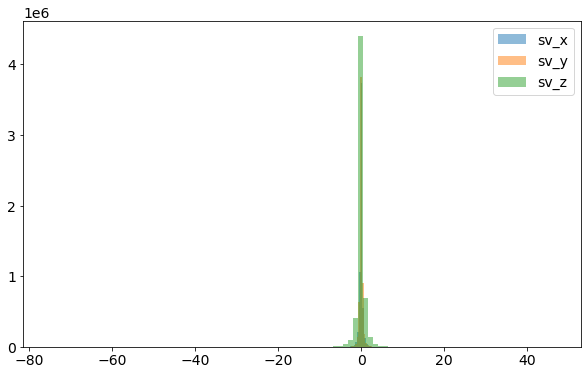

In [35]:
plt.hist(sv_df['sv_x_1'], bins=100, alpha=0.5, label='sv_x')
plt.hist(sv_df['sv_y_1'], bins=100, alpha=0.5, label='sv_y')
plt.hist(sv_df['sv_z_1'], bins=100, alpha=0.5, label='sv_z')
plt.legend()
plt.show()

75.29149657910683
[1534472 1040750  734034  530535  393867  297310  229271  179235  143232
  115151   93936   77179   64010   53373   45556   39188   33285   28588
   24743   21594   18793   16365   14586   12839   11384   10014    8976
    7915    7161    6460    5753    5292    4734    4284    3885    3511
    3179    2924    2560    2437    2238    1972    1927    1638    1525
    1418    1346    1209    1109    1042    1016     892     858     784
     672     647     622     531     586     476     473     450     372
     380     376     335     304     303     243     262     243     232
     219     195     187     179     156     158     133     150     144
     116     120      99      94     105      89     107      85      69
      85      65      61      68      74      65      55      63      35
      42      41      44      45      38      43      34      32      38
      33      31      28      19      40      25      29      18      23
      29      16      22      13 

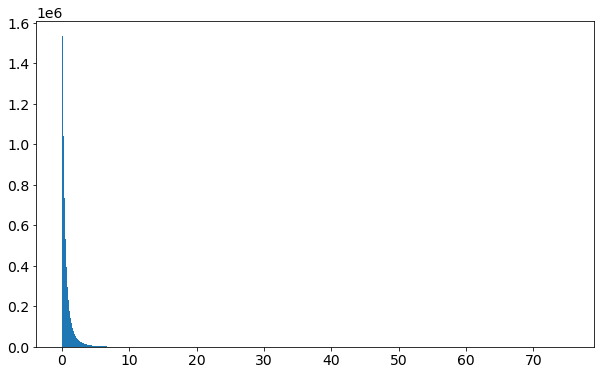

In [76]:
sv_1 = np.sqrt(df_gen['sv_x_1']**2 + df_gen['sv_y_1']**2 + df_gen['sv_z_1']**2)
print(max(sv_1))
hist, bin_edges = np.histogram(sv_1, bins=500)

print(hist)
plt.hist(sv_1, bins=500)
plt.show()

In [73]:
(sv_1>5).sum()

52494

Fit params: 0.0007957944363817757, 0.15351442035189425
Diag of cov: 2.3734655398110468e-09 , 1.9066149686234836e-05


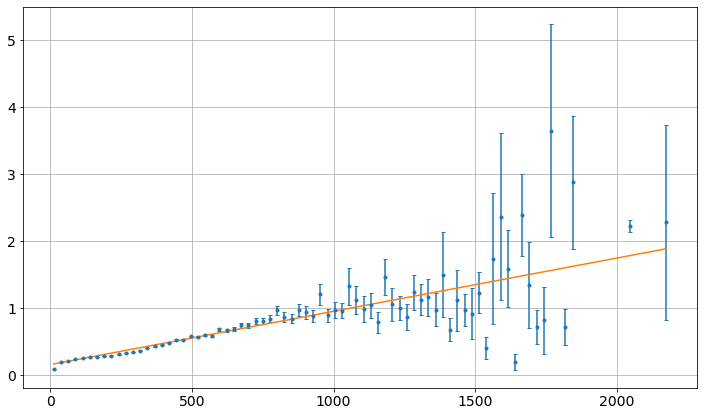

In [80]:
profileplot(sv_df['p_t_vis_1'], np.abs(sv_df['sv_x_1']), xlabel=r'', ylabel=r'', bins=100)
plt.show()

Fit params: 0.006096002132235139, 0.07016783196311625
Diag of cov: 2.1472147450381446e-09 , 9.80534420058444e-06
855.7739368211813


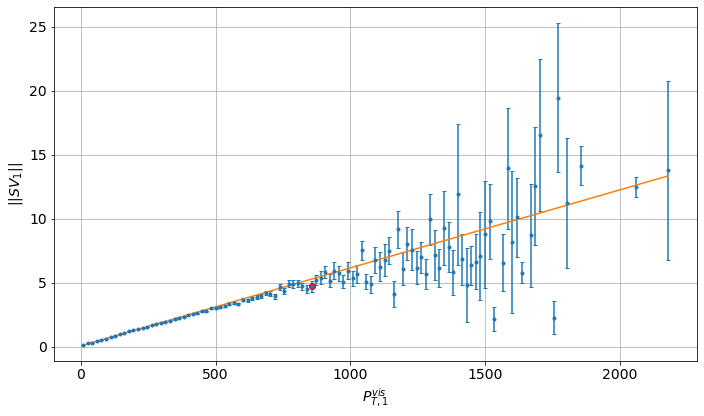

In [98]:
# profileplot(sv_df['p_t_vis_1'], np.abs(sv_df['sv_x_1']), xlabel=r'$P_{T,1}^{vis}$', ylabel=r'$|SV_1^x|$')
# profileplot(np.abs(sv_df['sv_y_1']), sv_df['p_t_vis_1'], xlabel=r'$|SV_1^y|$', ylabel=r'$P_{T,1}^{vis}$')
# profileplot(np.abs(sv_df['sv_z_1']), sv_df['p_t_vis_1'], xlabel=r'$|SV_1^z|$', ylabel=r'$P_{T,1}^{vis}$')
sv_1 = np.sqrt(sv_df['sv_x_1']**2 + sv_df['sv_y_1']**2 + sv_df['sv_z_1']**2)
_,_,x,y = profileplot(sv_df['p_t_vis_1'], sv_1, xlabel=r'$P_{T,1}^{vis}$', ylabel=r'$||SV_1||$', bins=150)
idx = 50
plt.plot(x[idx], y[idx], 'ro')
print(x[idx])
# plt.savefig('sv_analysis/profile_sv_1.png')
plt.show()

In [ ]:
x_fit_1, _ = profileplot(sv_df['p_t_vis_1'], sv_df['sv_x_1'], xlabel=r'$P_{T,1}^{vis}$', ylabel=r'$SV_1^x$', bins=150)
plt.savefig('fig_2.png')
# y_fit_1, _ = profileplot(sv_df['p_t_vis_1'], sv_df['sv_y_1'], xlabel=r'$P_{T,1}^{vis}$', ylabel=r'$SV_1^y$', bins=150)
# z_fit_1, _ = profileplot(sv_df['p_t_vis_1'], sv_df['sv_z_1'], xlabel=r'$P_{T,1}^{vis}$', ylabel=r'$SV_1^z$', bins=150)
# np.savetxt('sv_analysis/sv_fit_rho_rho_1.txt', np.vstack((x_fit_1, y_fit_1, z_fit_1)), delimiter=',')

Fit params: 0.00605188773186402, 0.08695657904664322
Diag of cov: 1.1421284475951212e-08 , 5.74820239212352e-05
756.2574800809682


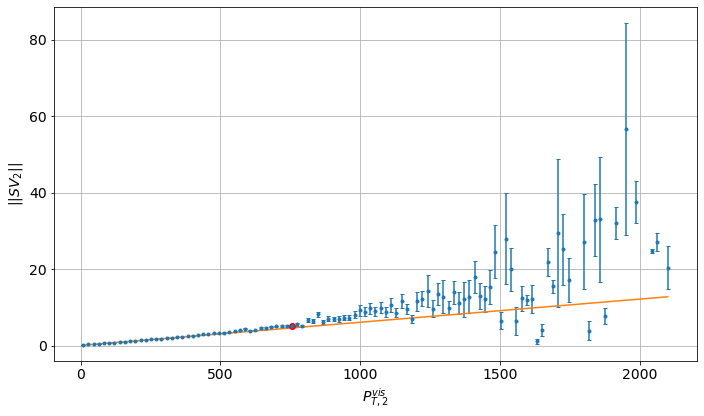

In [101]:
sv_2 = np.sqrt(sv_df['sv_x_2']**2 + sv_df['sv_y_2']**2 + sv_df['sv_z_2']**2)
_, _, x, y = profileplot(sv_df['p_t_vis_2'], sv_2, xlabel=r'$P_{T,2}^{vis}$', ylabel=r'$||SV_2||$', bins=200)
idx = 40
plt.plot(x[idx], y[idx], 'ro')
print(x[idx])
plt.savefig('sv_analysis/profile_sv_2.png')
plt.show()

In [ ]:
x_fit_2, _ = profileplot(sv_df['p_t_vis_2'], sv_df['sv_x_2'], xlabel=r'$P_{T,2}^{vis}$', ylabel=r'$SV_2^x$', bins=1000)
# y_fit_2, _ = profileplot(sv_df['p_t_vis_2'], sv_df['sv_y_2'], xlabel=r'$P_{T,2}^{vis}$', ylabel=r'$SV_2^y$', bins=1000)
# z_fit_2, _ = profileplot(sv_df['p_t_vis_2'], sv_df['sv_z_2'], xlabel=r'$P_{T,2}^{vis}$', ylabel=r'$SV_2^z$', bins=1000)
# np.savetxt('sv_analysis/sv_fit_rho_rho_2.txt', np.vstack((x_fit_2, y_fit_2, z_fit_2)), delimiter=',')

In [ ]:
three_d_scatterplot(sv_df['p_t_vis_1'], sv_df['sv_x_1'], sv_df['sv_y_1'], sv_df['sv_z_1'] )

In [ ]:
three_d_scatterplot(sv_df['p_t_vis_2'], sv_df['sv_x_2'], sv_df['sv_y_2'], sv_df['sv_z_2'] )

In [ ]:
# pi_1_boosted_rot = np.load('gen_info/pi_1_boosted_rot.npy', allow_pickle=True)
# pi_2_boosted_rot = np.load('gen_info/pi_2_boosted_rot.npy', allow_pickle=True)
# pi0_1_boosted_rot = np.load('gen_info/pi0_1_boosted_rot.npy', allow_pickle=True)
# pi0_2_boosted_rot = np.load('gen_info/pi0_2_boosted_rot.npy', allow_pickle=True)
# rho_1_boosted_rot = pi_1_boosted_rot + pi0_1_boosted_rot
# rho_2_boosted_rot = pi_2_boosted_rot + pi0_2_boosted_rot

In [ ]:
df_gen.columns

to do:  
- [ ] change units - ip is in cm

In [ ]:
df_reco.head()

In [ ]:
df_reco.columns

In [ ]:
def getSVFunctions(x_fit, y_fit, z_fit):
    x = np.poly1d(x_fit)
    y = np.poly1d(y_fit)
    z = np.poly1d(z_fit)
    return x, y, z

In [ ]:
fit_1 = np.vstack((x_fit_1, y_fit_1, z_fit_1))
fit_2 = np.vstack((x_fit_2, y_fit_2, z_fit_2))
c = 299792458
t_flight = 87e-6/c
f_1_x, f_1_y, f_1_z = getSVFunctions(*fit_1)
f_2_x, f_2_y, f_2_z = getSVFunctions(*fit_2)
p_t_1 = np.sqrt(df_reco['pi_px_1']**2+df_reco['pi_py_1']**2+df_reco['pi_pz_1']**2).to_numpy()
p_t_2 = np.sqrt(df_reco['pi_px_2']**2+df_reco['pi_py_2']**2+df_reco['pi_pz_2']**2).to_numpy()

SV_1_x, SV_1_y, SV_1_z = f_1_x(df_reco['pi_px_1']), f_1_y(df_reco['pi_py_1']), f_1_z(df_reco['pi_pz_1'])
SV_2_x, SV_2_y, SV_2_z = f_2_x(df_reco['pi_px_2']), f_2_y(df_reco['pi_py_2']), f_2_z(df_reco['pi_pz_2'])

# calculate in lab frame
# p_x_tau_1 = -m_tau*df['sv_x_1']/t_flight
# p_y_tau_1 = -m_tau*df['sv_y_1']/t_flight
# p_y_tau_1 = -m_tau*df['sv_y_1']/t_flight
# # need to convert units of p
# E_tau_1 = np.sqrt(p_x_tau_1**2+p_y_tau_1**2+p_z_tau_1**2+m_tau**2)


# try fitting p_t instead of each component

In [ ]:
plt.figure()
# plt.hist(SV_1_x, density=True)
plt.hist(sv_df['sv_x_1'], bins=100)
# plt.xlim(-0.002,0.002)
plt.show()

In [ ]:
plt.clf()

In [ ]:
l_tau = 87e-4 # in cm
# testing sandbox
for i in range(100):
    vis_dir = rho_1[:,i][1:]/np.linalg.norm(rho_1[:,i][1:])
    ip = ip_1[i]
    delta = vis_dir.dot(ip)**2 - (np.linalg.norm(ip)**2-l_tau**2)
    d_plus = -vis_dir.dot(ip) + delta
    d_minus = -vis_dir.dot(ip) - delta
    # todo: transform d to a point
    if delta > 0:
        sv_1 = d_plus*vis_dir
        sv_2 = d_minus*vis_dir
    else:
        pass